**Importing the data from kaggle**

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle datasets download -d sachinkumar413/diabetic-retinopathy-dataset

diabetic-retinopathy-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip diabetic-retinopathy-dataset.zip

**Importing the dependencies**

In [4]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, accuracy_score

In [5]:
data = []                # reading the images and the labels
for dirs in os.listdir("/content/data"):
  new_path = os.path.join("/content/data", dirs)
  class_name = dirs
  for img in os.listdir(new_path):
    img_arr = cv.imread(os.path.join(new_path, img), cv.IMREAD_GRAYSCALE)
    re = cv.resize(img_arr, (128,128))
    data.append([re, class_name])

In [6]:
np.random.shuffle(data)     # shuffling the dataset

In [7]:
images = []                    # unpacking the data array into images and labels
labels = []

for features, label in data:
  images.append(features)
  labels.append(label) 

In [8]:
encoding = {'Moderate DR' : 0, 'Healthy' : 1, 'Proliferate DR' : 2, 'Severe DR' : 3, 'Mild DR' : 4}    # encoder dictionary

In [9]:
for i in range(len(labels)):    # encoding the labels
  labels[i] = encoding.get(labels[i])

In [10]:
images = np.array(images)
labels = np.array(labels)

In [11]:
images = np.expand_dims(images, axis=3)    # adding an extra dimension to the images array

In [12]:
print(f"shape of the images are {images.shape}")
print(f"shape of the labels are {labels.shape}")

shape of the images are (2750, 128, 128, 1)
shape of the labels are (2750,)


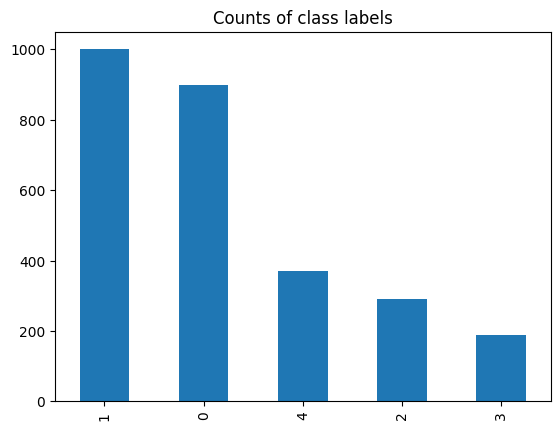

In [13]:
df = pd.DataFrame(data={"labels": labels})
df["labels"].value_counts().plot(kind="bar")
plt.title("Counts of class labels")
plt.show()

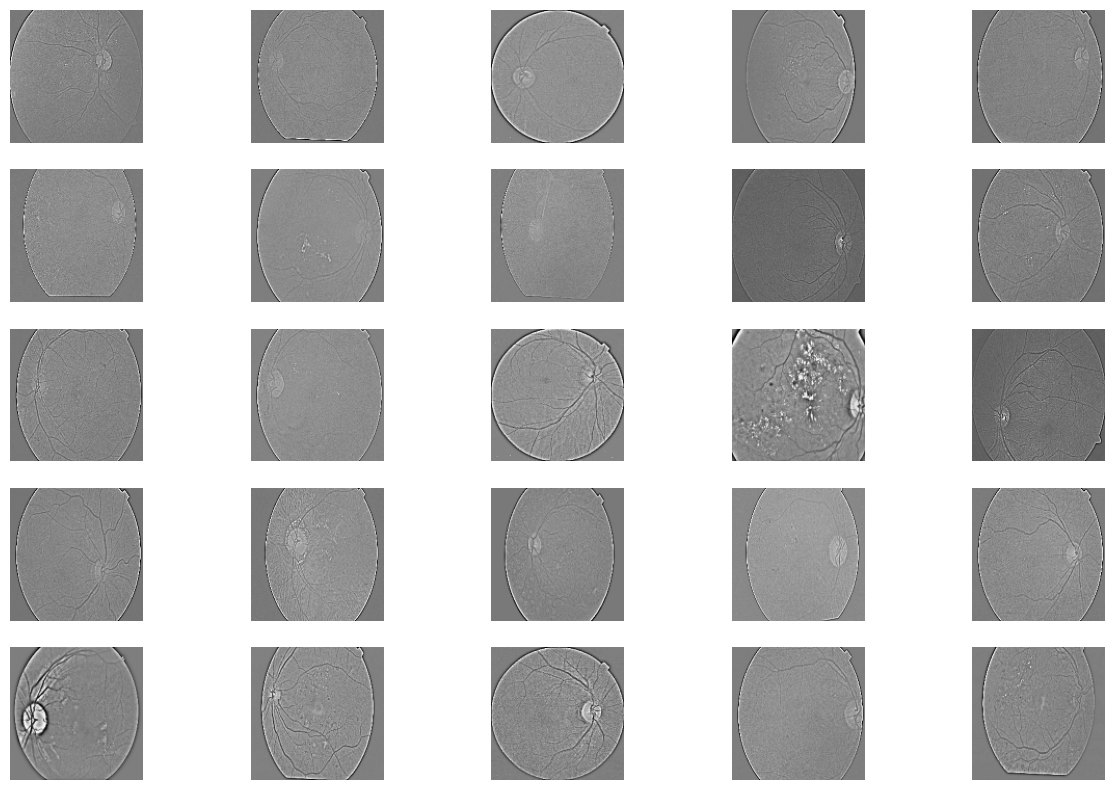

In [14]:
plt.figure(figsize=(15,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i], cmap='gray')
  plt.axis("off")
plt.show()

In [15]:
images = images/255.0            # normalizing the images

In [16]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

In [17]:
print(f"shape of x_train {x_train.shape}")
print(f"shape of y_train {y_train.shape}")
print(f"shape of x_test {x_test.shape}")
print(f"shape of y_test {y_test.shape}")

shape of x_train (2200, 128, 128, 1)
shape of y_train (2200,)
shape of x_test (550, 128, 128, 1)
shape of y_test (550,)


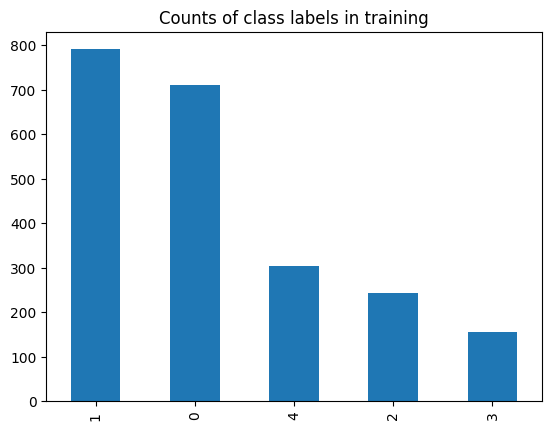

In [19]:
df = pd.DataFrame(data={"labels": y_train})
df["labels"].value_counts().plot(kind="bar")
plt.title("Counts of class labels in training")
plt.show()

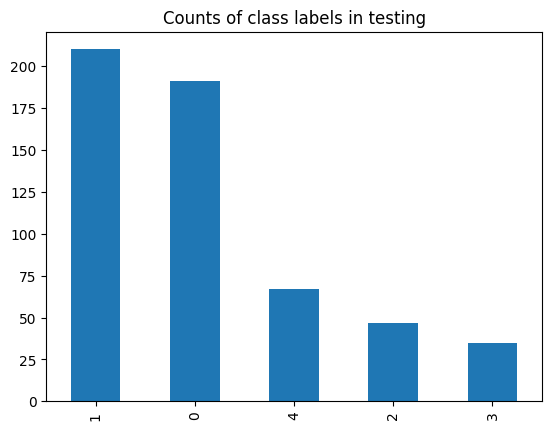

In [18]:
df = pd.DataFrame(data={"labels": y_test})
df["labels"].value_counts().plot(kind="bar")
plt.title("Counts of class labels in testing")
plt.show()

In [20]:
class_weights = {0 : 0.3, 1 : 0.3, 2 : 0.7, 3 : 0.6, 4 : 0.4}        # giving weights to class

**CNN Model 1**

In [21]:
model1 = Sequential()

model1.add(Conv2D(32, (3,3), input_shape=(128,128,1), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(64, (3,3),activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(128, (3,3),activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Flatten())
model1.add(Dense(100, activation="relu"))
model1.add(Dense(5, activation="softmax"))

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [23]:
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [24]:
history1 = model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100, class_weight = class_weights)

Epoch 1/100
69/69 [==============================] - 11s 32ms/step - loss: 0.4939 - accuracy: 0.5355 - val_loss: 1.0564 - val_accuracy: 0.5364
Epoch 2/100
69/69 [==============================] - 1s 21ms/step - loss: 0.4199 - accuracy: 0.6014 - val_loss: 1.1655 - val_accuracy: 0.4327
Epoch 3/100
69/69 [==============================] - 1s 21ms/step - loss: 0.4049 - accuracy: 0.6223 - val_loss: 0.9132 - val_accuracy: 0.6745
Epoch 4/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3794 - accuracy: 0.6586 - val_loss: 0.9072 - val_accuracy: 0.6691
Epoch 5/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3600 - accuracy: 0.6714 - val_loss: 0.8613 - val_accuracy: 0.6891
Epoch 6/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3412 - accuracy: 0.6859 - val_loss: 0.8828 - val_accuracy: 0.6527
Epoch 7/100
69/69 [==============================] - 2s 25ms/step - loss: 0.3147 - accuracy: 0.7132 - val_loss: 0.8812 - val_accuracy: 0.6600
Epoch

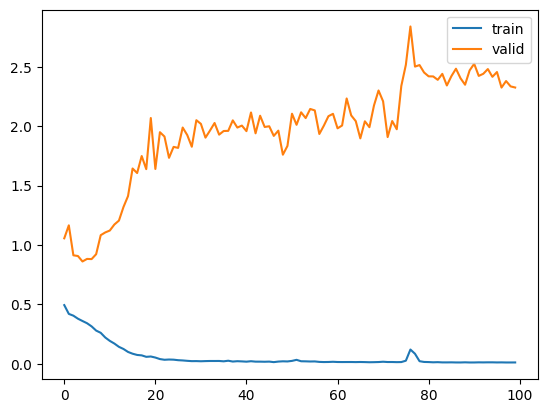

In [25]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.legend(["train", "valid"])
plt.show()

In [26]:
y_pred1 = model1.predict(x_test)

18/18 [==============================] - 0s 7ms/step


<Axes: >

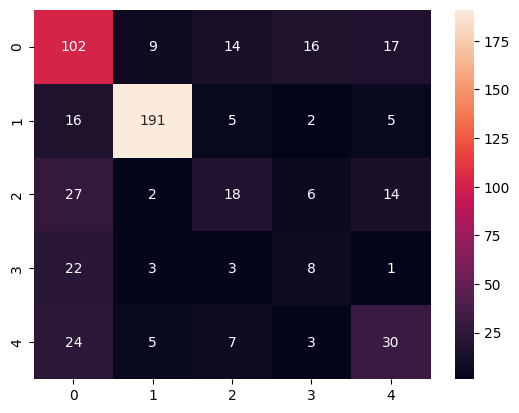

In [27]:
sns.heatmap(confusion_matrix(y_pred1.argmax(axis=1), y_test), annot=True, fmt="g")

**CNN Model 2**

In [28]:
model2 = Sequential()

model2.add(Conv2D(32, (3,3), input_shape=(128,128,1), activation="relu"))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.1))
model2.add(Conv2D(64, (3,3), activation="relu"))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.2))
model2.add(Conv2D(128, (3,3), activation="relu"))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.3))
model2.add(GlobalAveragePooling2D())
model2.add(Dense(200, activation="relu"))
model2.add(Dense(5, activation="softmax"))

In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)       

In [30]:
model2.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics=['accuracy'])

In [31]:
history2 = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100, class_weight = class_weights)

Epoch 1/100
69/69 [==============================] - 4s 32ms/step - loss: 0.5867 - accuracy: 0.3541 - val_loss: 1.3937 - val_accuracy: 0.3909
Epoch 2/100
69/69 [==============================] - 2s 24ms/step - loss: 0.5183 - accuracy: 0.4991 - val_loss: 1.1717 - val_accuracy: 0.6073
Epoch 3/100
69/69 [==============================] - 2s 24ms/step - loss: 0.4919 - accuracy: 0.5727 - val_loss: 1.1529 - val_accuracy: 0.6145
Epoch 4/100
69/69 [==============================] - 2s 24ms/step - loss: 0.4859 - accuracy: 0.5827 - val_loss: 1.1477 - val_accuracy: 0.6182
Epoch 5/100
69/69 [==============================] - 2s 25ms/step - loss: 0.4794 - accuracy: 0.5850 - val_loss: 1.1388 - val_accuracy: 0.6145
Epoch 6/100
69/69 [==============================] - 2s 22ms/step - loss: 0.4809 - accuracy: 0.5850 - val_loss: 1.1440 - val_accuracy: 0.6273
Epoch 7/100
69/69 [==============================] - 2s 23ms/step - loss: 0.4772 - accuracy: 0.5891 - val_loss: 1.1336 - val_accuracy: 0.6236
Epoch 

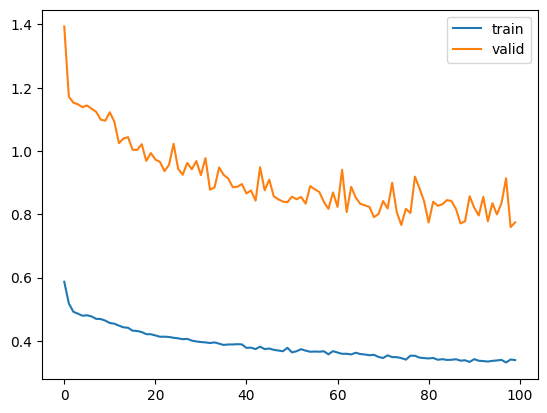

In [32]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.legend(["train", "valid"])
plt.show()

In [33]:
y_pred2 = model2.predict(x_test)

18/18 [==============================] - 0s 5ms/step


<Axes: >

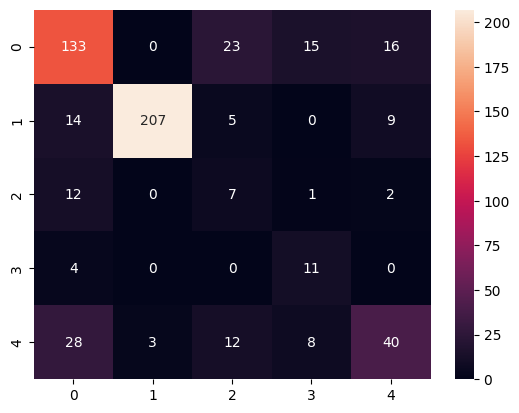

In [34]:
sns.heatmap(confusion_matrix(y_pred2.argmax(axis=1), y_test), annot=True, fmt="g")

**CNN Model 3**

In [35]:
model3 = Sequential()

model3.add(Conv2D(32, (3,3), input_shape=(128,128,1), activation="relu"))
model3.add(Conv2D(32, (3,3), activation="relu"))
model3.add(MaxPool2D(2,2))

model3.add(Conv2D(64, (3,3), input_shape=(128,128,1), activation="relu"))
model3.add(Conv2D(64, (3,3), activation="relu"))
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.1))

model3.add(Conv2D(128, (3,3), input_shape=(128,128,1), activation="relu"))
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.2))

model3.add(GlobalAveragePooling2D())
model3.add(Dense(128, activation="relu"))
model3.add(Dense(5, activation="softmax"))


In [36]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                  

In [37]:
model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [38]:
history3 = model3.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100, class_weight = class_weights)

Epoch 1/100
69/69 [==============================] - 9s 61ms/step - loss: 0.5841 - accuracy: 0.3582 - val_loss: 1.3725 - val_accuracy: 0.4473
Epoch 2/100
69/69 [==============================] - 3s 44ms/step - loss: 0.5167 - accuracy: 0.5405 - val_loss: 1.2058 - val_accuracy: 0.6055
Epoch 3/100
69/69 [==============================] - 3s 46ms/step - loss: 0.4913 - accuracy: 0.5795 - val_loss: 1.1805 - val_accuracy: 0.6109
Epoch 4/100
69/69 [==============================] - 3s 44ms/step - loss: 0.4845 - accuracy: 0.5845 - val_loss: 1.2057 - val_accuracy: 0.6127
Epoch 5/100
69/69 [==============================] - 3s 43ms/step - loss: 0.4795 - accuracy: 0.5868 - val_loss: 1.1459 - val_accuracy: 0.6182
Epoch 6/100
69/69 [==============================] - 3s 43ms/step - loss: 0.4722 - accuracy: 0.5986 - val_loss: 1.1063 - val_accuracy: 0.6236
Epoch 7/100
69/69 [==============================] - 3s 46ms/step - loss: 0.4719 - accuracy: 0.5968 - val_loss: 1.1361 - val_accuracy: 0.6145
Epoch 

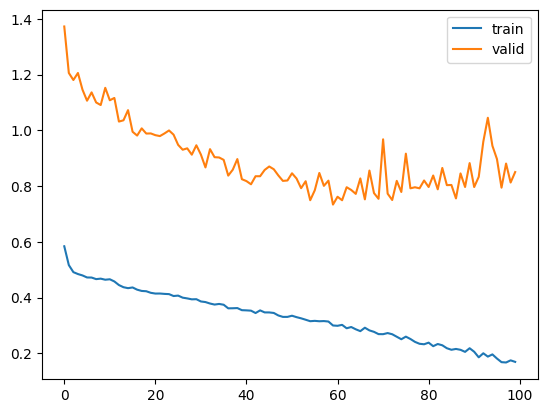

In [39]:
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])
plt.legend(["train", "valid"])
plt.show()

In [40]:
y_pred3 = model3.predict(x_test)

18/18 [==============================] - 0s 11ms/step


<Axes: >

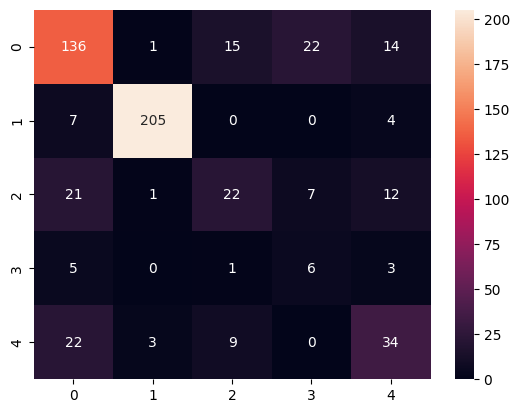

In [41]:
sns.heatmap(confusion_matrix(y_pred3.argmax(axis=1), y_test), annot=True, fmt="g")

**Ensemble Prediction**

In [42]:
model = [model1, model2, model3]            # creating list of the 3 cnn models
preds = [model.predict(x_test) for model in model]

18/18 [==============================] - 0s 9ms/step


In [43]:
preds = np.array(preds)       # getting the prediction

In [44]:
preds.shape

(3, 550, 5)

In [45]:
preds = np.sum(preds, axis=0)        # summing up the prediction of the 3 models

In [46]:
preds.shape

(550, 5)

In [47]:
ensemble_result = np.argmax(preds, axis=1)      # ensemble prediction

In [48]:
print(f"accuracy of model 1 {accuracy_score(y_pred1.argmax(axis=1), y_test)}")
print(f"accuracy of model 2 {accuracy_score(y_pred2.argmax(axis=1), y_test)}")
print(f"accuracy of model 3 {accuracy_score(y_pred3.argmax(axis=1), y_test)}")
print(f"ensemble accuracy {accuracy_score(ensemble_result, y_test)}")

accuracy of model 1 0.6345454545454545
accuracy of model 2 0.7236363636363636
accuracy of model 3 0.7327272727272728
ensemble accuracy 0.7254545454545455


**Predicting with giving weights to the models**

In [49]:
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]

18/18 [==============================] - 0s 8ms/step


In [50]:
preds = np.array(preds)

In [51]:
weights = [0.6, 0.6, 0.3]     # giving weights to the models , weights can be assigned according to the importance of the model

In [52]:
weighted_preds = np.tensordot(preds, weights, axes=((0), (0)))

In [53]:
weighted_preds.shape

(550, 5)

In [54]:
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

In [55]:
print(f"the accuracy of weighted ensemble prediction is {accuracy_score(weighted_ensemble_prediction, y_test)}")

the accuracy of weighted ensemble prediction is 0.7036363636363636


**Grid Search for Weighted Ensemble Prediction**

In [56]:
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds = np.array(preds)

18/18 [==============================] - 0s 8ms/step


In [57]:
weights1 = []
weights2 = []
weights3 = []
acc = []
for w1 in range(0, 5):
  for w2 in range(0, 5):
    for w3 in range(0, 5):
      wts = [w1/10., w2/10., w3/10.]
      wt_pred = np.tensordot(preds, wts, axes=((0), (0)))
      wtd_ensemble_pred = np.argmax(wt_pred, axis=1)
      weighted_accuracy = accuracy_score(wtd_ensemble_pred, y_test)
      weights1.append(wts[0])
      weights2.append(wts[1])
      weights3.append(wts[2])
      acc.append(weighted_accuracy)

In [58]:
df = pd.DataFrame({"w1" : weights1, "w2" : weights2, "w3" : weights3, "acc" : acc})

In [59]:
df.head()

,w1,w2,w3,acc
0,0.0,0.0,0.0,0.347273
1,0.0,0.0,0.1,0.732727
2,0.0,0.0,0.2,0.732727
3,0.0,0.0,0.3,0.732727
4,0.0,0.0,0.4,0.732727


In [60]:
max_acc_row = df.iloc[df["acc"].idxmax()]

In [61]:
print(f"the highest ensemble accuracy is {max_acc_row[3]}")

the highest ensemble accuracy is 0.7527272727272727


**Random Forest Classifier**

In [62]:
rf_clf = RandomForestClassifier()

In [63]:
x_train_reshaped = x_train.reshape(x_train.shape[0],-1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

In [64]:
print(f"shape of x_train_reshaped {x_train_reshaped.shape}")
print(f"shape of x_test_reshaped {x_test_reshaped.shape}")

shape of x_train_reshaped (2200, 16384)
shape of x_test_reshaped (550, 16384)


In [65]:
rf_clf.fit(x_train_reshaped, y_train)

RandomForestClassifier()

In [66]:
y_pred_rf = rf_clf.predict(x_test_reshaped)

In [67]:
accuracy_score(y_pred_rf, y_test)

0.7072727272727273

<Axes: >

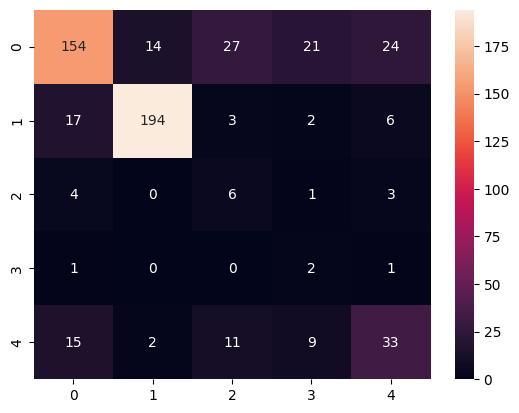

In [68]:
sns.heatmap(confusion_matrix(y_pred_rf, y_test), annot=True, fmt="g")

**XGBoost Classifier**

In [69]:
xgb_clf = xgb.XGBClassifier()

In [70]:
xgb_clf.fit(x_train_reshaped, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [71]:
y_pred_xgb = xgb_clf.predict(x_test_reshaped)

In [72]:
accuracy_score(y_pred_xgb, y_test)

0.6945454545454546

<Axes: >

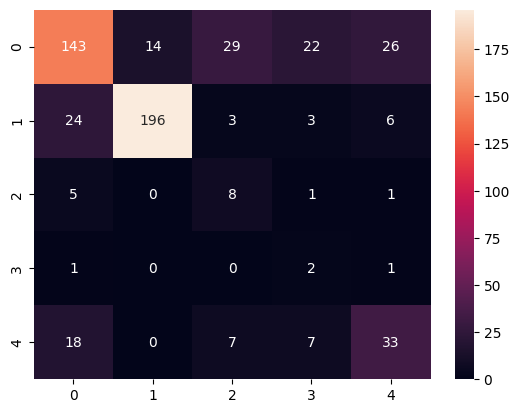

In [73]:
sns.heatmap(confusion_matrix(y_pred_xgb, y_test), annot=True, fmt="g")